In [1]:
import os
import tensorflow as tf
import dask
import dask.array as da
import numpy as np
from PIL import Image
from skimage.transform import resize
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
train_x = da.from_npy_stack('/home/skyolia/JupyterProjects/data/DRIVE/train_x')
train_y = da.from_npy_stack('/home/skyolia/JupyterProjects/data/DRIVE/train_y')
test_x = da.from_npy_stack('/home/skyolia/JupyterProjects/data/DRIVE/test_x')
test_y = da.from_npy_stack('/home/skyolia/JupyterProjects/data/DRIVE/test_y')
test_fov = da.from_npy_stack('/home/skyolia/JupyterProjects/data/DRIVE/test_fov')
train_x, train_y, test_x, test_y, test_fov

(dask.array<from-npy-stack, shape=(20, 512, 512, 1), dtype=float32, chunksize=(20, 512, 512, 1)>,
 dask.array<from-npy-stack, shape=(20, 512, 512, 1), dtype=float32, chunksize=(20, 512, 512, 1)>,
 dask.array<from-npy-stack, shape=(20, 512, 512, 1), dtype=float32, chunksize=(20, 512, 512, 1)>,
 dask.array<from-npy-stack, shape=(20, 512, 512, 1), dtype=float32, chunksize=(20, 512, 512, 1)>,
 dask.array<from-npy-stack, shape=(20, 512, 512), dtype=float32, chunksize=(20, 512, 512)>)

In [4]:
def build_block(input_layer, filters, norm=True, k=(3, 3)):
    layer = tf.keras.layers.Conv2D(filters, kernel_size=k, padding='same', use_bias=not norm, kernel_initializer='glorot_normal')(input_layer)
    if norm:
        layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Activation('elu')(layer)
    return layer

def build_unet(input_shape, n_filters=16, dropout=0.2):
    image_input = tf.keras.Input(shape=input_shape, name='input_layer')
    
    conv_1 = build_block(image_input, n_filters)
    conv_2 = build_block(conv_1, n_filters)
    pool_1 = tf.keras.layers.AveragePooling2D(padding='same')(conv_2)
    drop_1 = tf.keras.layers.SpatialDropout2D(dropout)(pool_1)
    
    conv_3 = build_block(drop_1, n_filters * 2)
    conv_4 = build_block(conv_3, n_filters * 2)
    pool_2 = tf.keras.layers.AveragePooling2D(padding='same')(conv_4)
    drop_2 = tf.keras.layers.SpatialDropout2D(dropout)(pool_2)
    
    conv_5 = build_block(drop_2, n_filters * 4)
    conv_6 = build_block(conv_5, n_filters * 4)
    pool_3 = tf.keras.layers.AveragePooling2D(padding='same')(conv_6)
    drop_3 = tf.keras.layers.SpatialDropout2D(dropout)(pool_3)
    
    conv_7 = build_block(drop_3, n_filters * 8)
    conv_8 = build_block(conv_7, n_filters * 8)
    pool_4 = tf.keras.layers.AveragePooling2D(padding='same')(conv_8)
    drop_4 = tf.keras.layers.SpatialDropout2D(dropout)(pool_4)
    
    conv_9 = build_block(drop_4, n_filters * 16)
    conv_10 = build_block(conv_9, n_filters * 16)
    
    upsp_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_10) #(-1, 8, 8, 256)
    upsp_1 = tf.keras.layers.concatenate([upsp_1, conv_8])#(-1, 8, 8, 384)
    conv_11 = build_block(upsp_1, n_filters * 8)#(-1, 8, 8, 128)
    conv_12 = build_block(conv_11, n_filters * 8)#(-1, 8, 8, 128)
    drop_5 = tf.keras.layers.SpatialDropout2D(dropout)(conv_12)#(-1, 8, 8, 128)
    
    upsp_2 = tf.keras.layers.UpSampling2D(size=(2, 2))(drop_5) #(-1, 16, 16, 128)
    upsp_2 = tf.keras.layers.concatenate([upsp_2, conv_6]) #(-1, 16, 16, 192)
    conv_13 = build_block(upsp_2, n_filters * 4) #(-1, 16, 16, 64)
    conv_14 = build_block(conv_13, n_filters * 4) #(-1, 16, 16, 64)
    drop_6 = tf.keras.layers.SpatialDropout2D(dropout)(conv_14) #(-1, 16, 16, 64)
    
    upsp_3 = tf.keras.layers.UpSampling2D(size=(2, 2))(drop_6) #(-1, 32, 32, 64)
    upsp_3 = tf.keras.layers.concatenate([upsp_3, conv_4]) #(-1, 32, 32, 96)
    conv_15 = build_block(upsp_3, n_filters * 2) #(-1, 32, 32, 32)
    conv_16 = build_block(conv_15, n_filters * 2) #(-1, 32, 32, 32)
    drop_7 = tf.keras.layers.SpatialDropout2D(dropout)(conv_16) #(-1, 32, 32, 32)
    
    upsp_4 = tf.keras.layers.UpSampling2D(size=(2, 2))(drop_7) #(-1, 64, 64, 32)
    upsp_4 = tf.keras.layers.concatenate([upsp_4, conv_2])#(-1, 64, 64, 48)
    conv_17 = build_block(upsp_4, n_filters * 2)#(-1, 64, 64, 16)
    conv_18 = build_block(conv_17, n_filters * 2)#(-1, 64, 64, 16)
    drop_8 = tf.keras.layers.SpatialDropout2D(dropout)(conv_18)#(-1, 64, 64, 16)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), kernel_initializer='glorot_normal', activation='sigmoid')(drop_8)
    model = tf.keras.Model(inputs=image_input, outputs=output)
    return model

def random_crop(img, msk, random_crop_size):
    # Note: image_data_format is 'channel_last'
    #assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :], msk[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_x_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, batch_x.shape[3]))
        batch_y_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, batch_x.shape[3]))
        for i in range(batch_x.shape[0]):
            batch_x_crops[i], batch_y_crops[i] = random_crop(batch_x[i], batch_y[i], (crop_length, crop_length))
        yield (batch_x_crops, batch_y_crops)

In [5]:
model = build_unet(input_shape=(None, None, 1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 144         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 1 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 1 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [5]:
epochs, batch_size, lr, filepath = 1000000, 4, 0.001, "day__.weights.best.hdf5"
steps_per_epoch = int(np.ceil(train_y.shape[0]/batch_size))

data_gen_args = dict(horizontal_flip=True, vertical_flip=True) #width_shift_range=0.1, height_shift_range=0.1, 
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(train_x, augment=True, seed=seed)
mask_datagen.fit(train_y, augment=True, seed=seed)

image_generator = image_datagen.flow(x=train_x, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(x=train_y, batch_size=batch_size, seed=seed)
train_generator = crop_generator(zip(image_generator, mask_generator), 64)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow(x=test_x, y=test_y, batch_size=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
tb = tf.keras.callbacks.TensorBoard(log_dir=os.getcwd())

opt = tf.keras.optimizers.Adam() # 
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    verbose=1,
                    validation_data=test_generator,
                    validation_steps=int(np.ceil(test_y.shape[0]/batch_size)),
                    use_multiprocessing=False,
                    workers=12,
                    shuffle=True,
                    #initial_epoch=65,
                    callbacks=[checkpoint, tb])

Epoch 1/1000000
3/5 [=================>............] - ETA: 4s - loss: 2.8528 - acc: 0.5202 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-1a0fb27c26f3>", line 33, in <module>
    callbacks=[checkpoint, tb])
  File "/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 2065, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_generator.py", line 168, in fit_generator
    callbacks.on_batch_begin(batch_index, batch_logs)
  File "/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/tensorflow/python/keras/callbacks.py", line 228, in on_batch_begin
    delta_t_median = np.median(self._delta_ts_batch_begin)
  File "/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/

KeyboardInterrupt: 

In [6]:
model.load_weights("day_2.weights.best.hdf5")
opt = tf.keras.optimizers.Adam() # 
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
scores = model.evaluate(test_x, test_y, batch_size=1)
scores

20/20 [==============================] - 3s 136ms/step


[0.0853958860039711, 0.9226659774780274]

In [8]:
pred = model.predict(x=test_x,batch_size=1)
pred.shape

(20, 512, 512, 1)

In [9]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, confusion_matrix
bin_test_y = np.where(test_y.compute()>0.5, 1, 0)
bin_pred = np.where(pred>0.5, 1, 0)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(bin_test_y.ravel(), pred.ravel())
auc_keras = auc(fpr_keras, tpr_keras)
auc_roc = roc_auc_score(bin_test_y.ravel(), pred.ravel())
auc_keras, auc_roc

(0.9856875161085952, 0.9856875161085952)

In [14]:
F1_score = f1_score(bin_test_y.ravel(), bin_pred.ravel(), labels=None, average='binary', sample_weight=None)
F1_score

0.8143695644798299

In [10]:
cm = confusion_matrix(bin_test_y.ravel(), bin_pred.ravel())

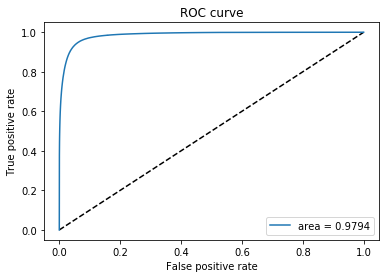

In [11]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = '+str(0.9794))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

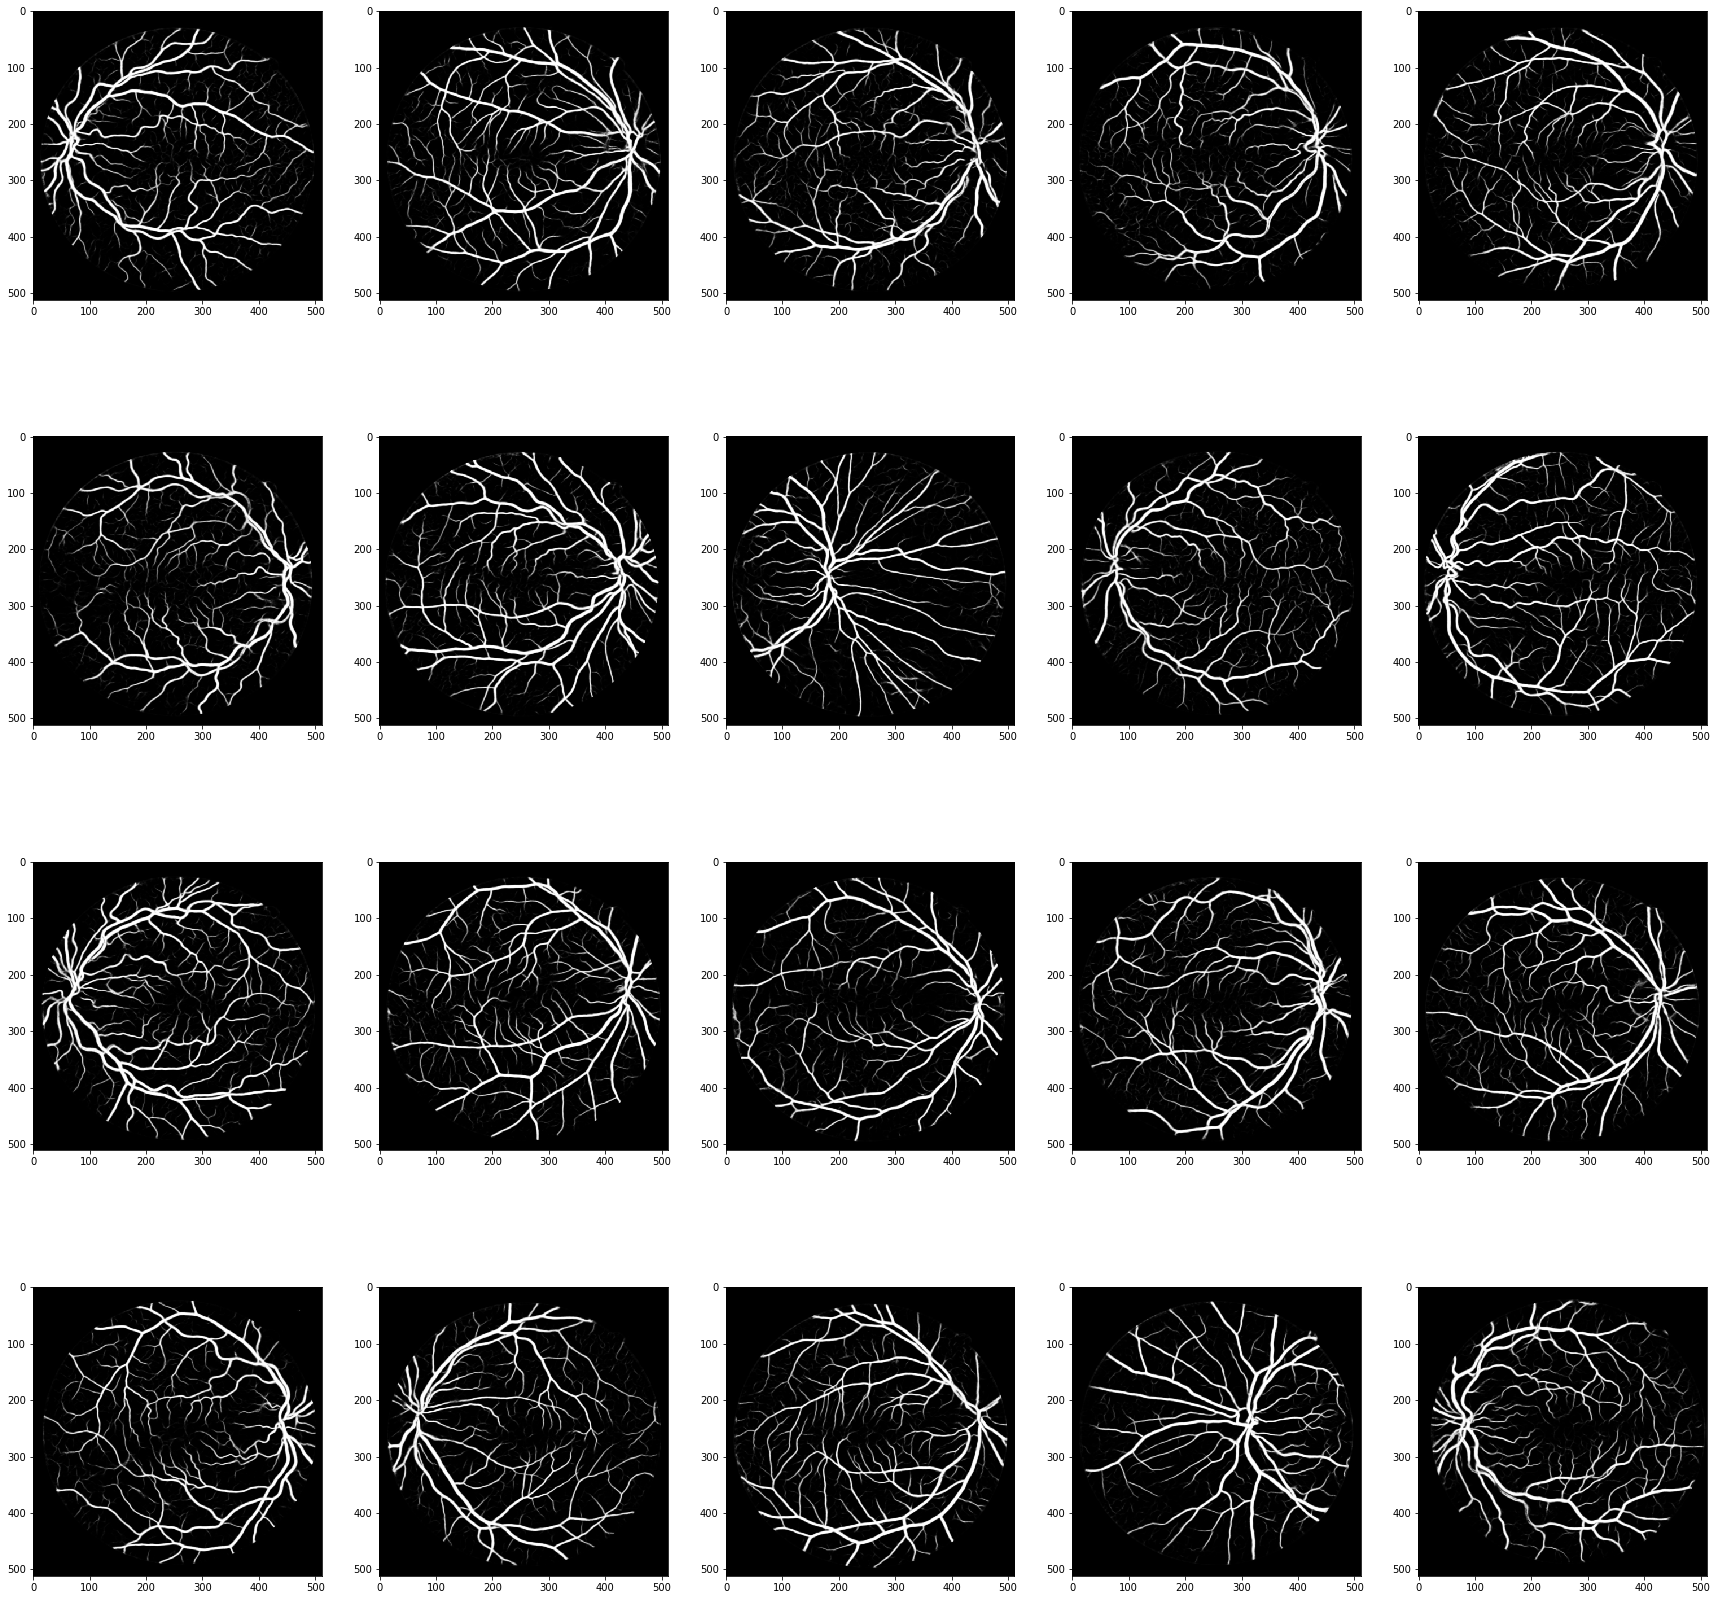

In [17]:
rnd_ind = np.random.choice(20, 20, False)
fig=plt.figure(figsize=(30, 30))
columns = 5
rows = 4
for x, i in enumerate(rnd_ind):
    fig.add_subplot(rows, columns, x+1)
    plt.imshow(np.squeeze(pred[i]), cmap=plt.get_cmap('gray'))
plt.show()

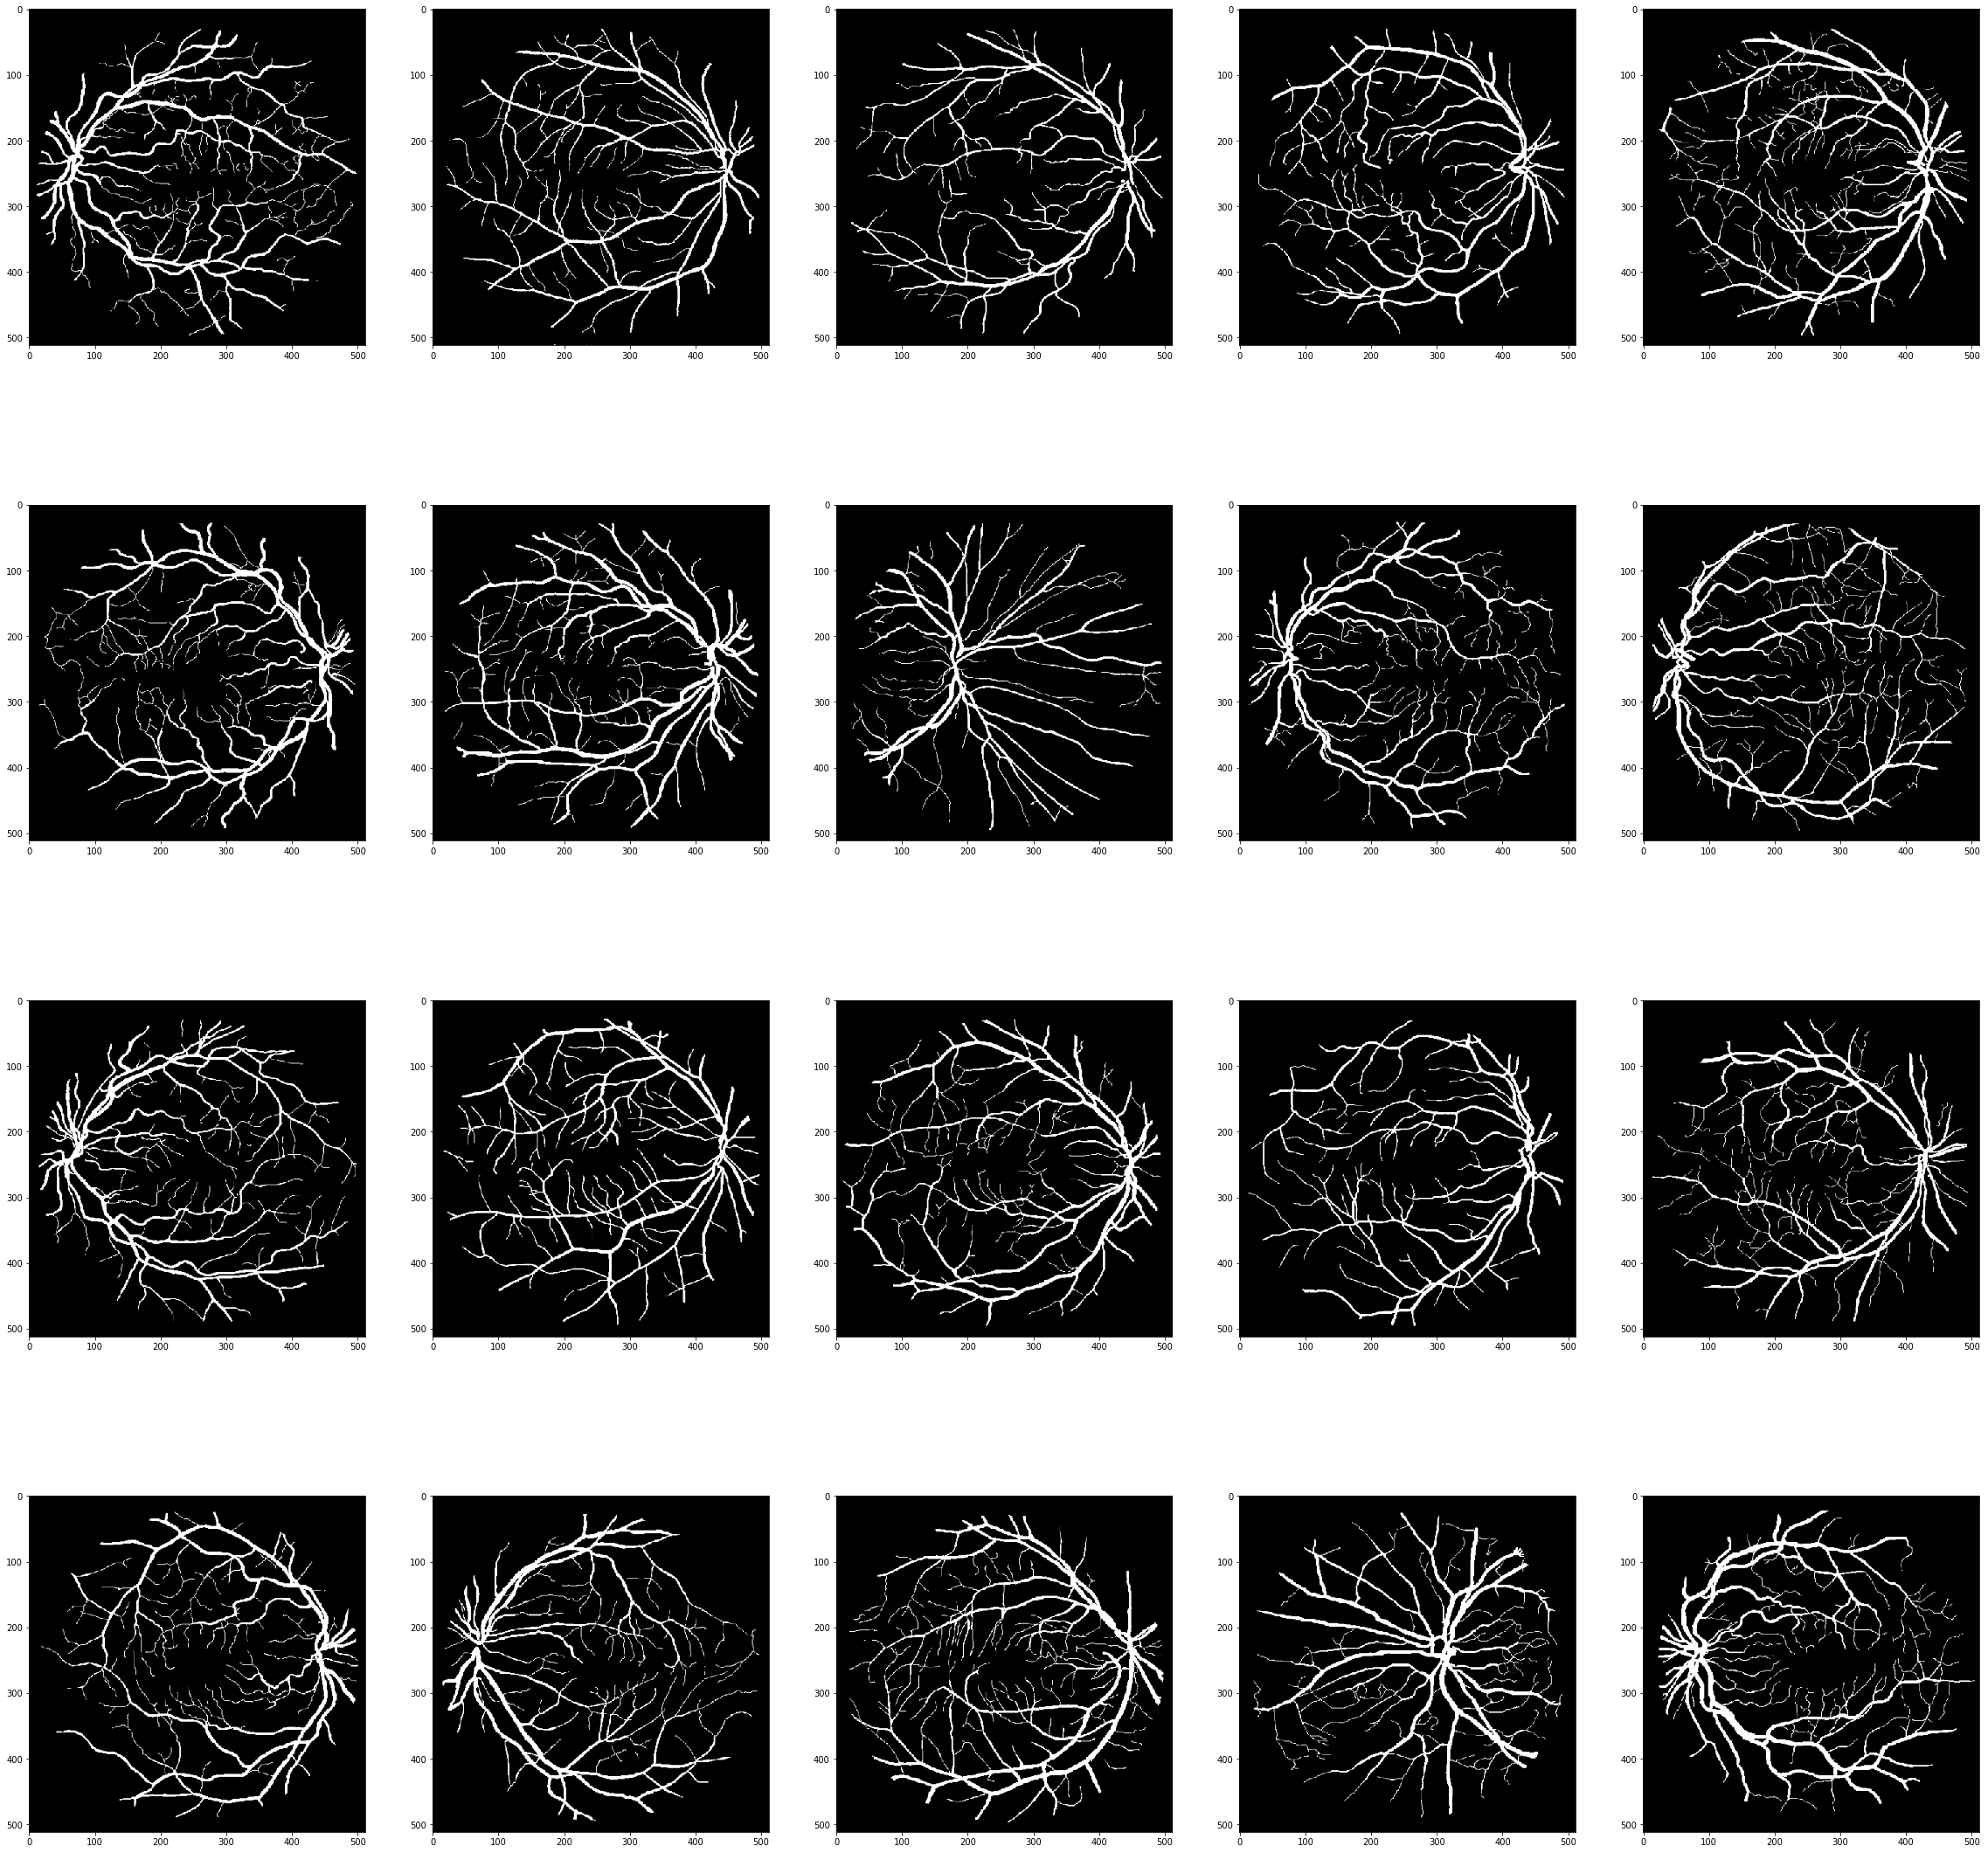

In [18]:
#rnd_ind = np.random.choice(20, 20, False)
fig=plt.figure(figsize=(40, 40))
columns = 5
rows = 4
for x, i in enumerate(rnd_ind):
    fig.add_subplot(rows, columns, x+1)
    plt.imshow(np.squeeze(test_y[i]), cmap=plt.get_cmap('gray'))
plt.show()

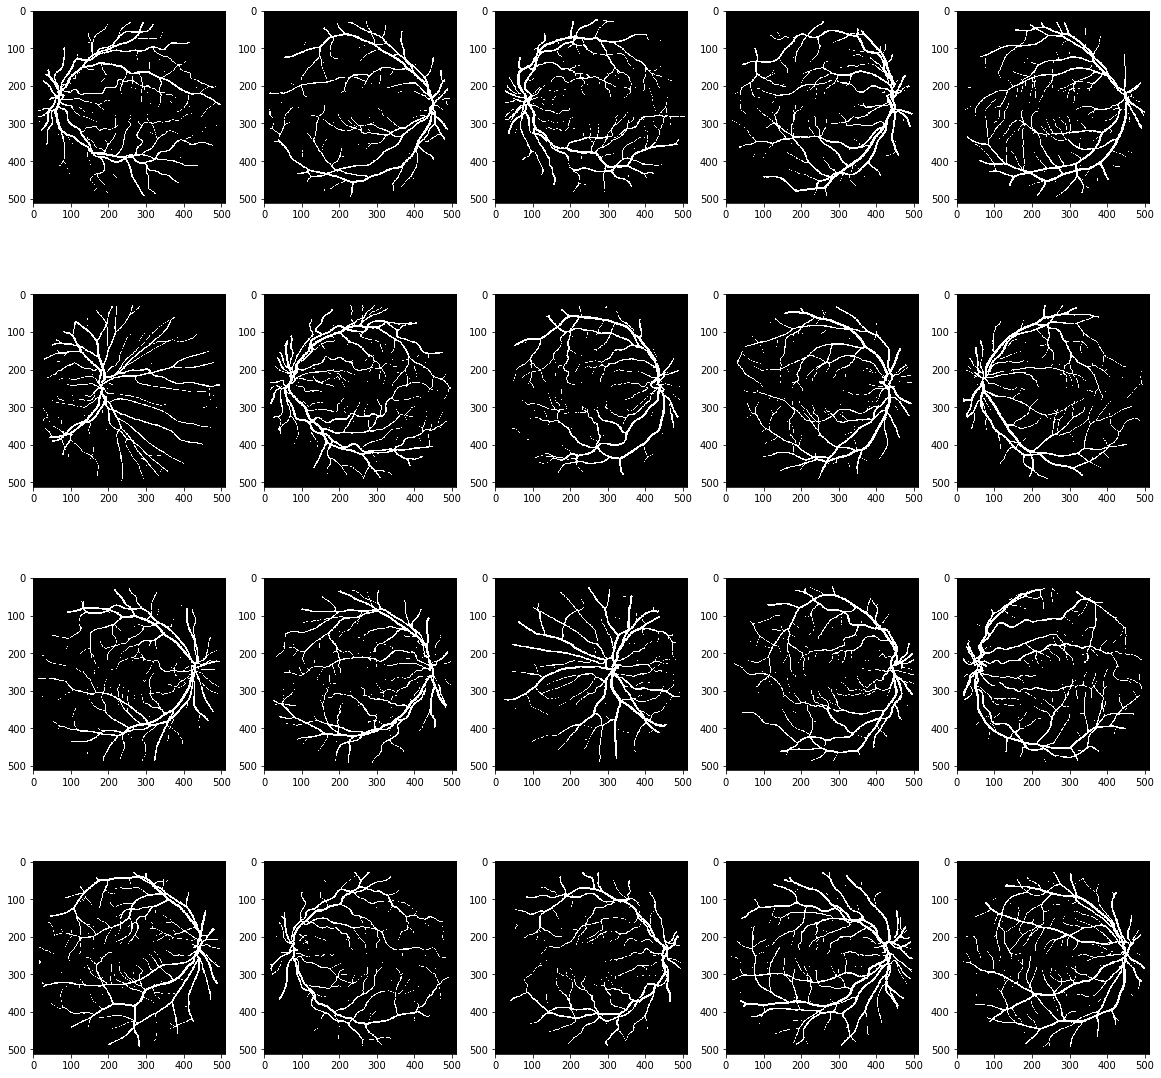

In [29]:
#rnd_ind = np.random.choice(20, 20, False)
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 4
bin_pred = np.where(pred>0.5, 1, 0)
for x, i in enumerate(rnd_ind):
    fig.add_subplot(rows, columns, x+1)
    plt.imshow(np.squeeze(bin_pred[i]), cmap=plt.get_cmap('gray'))
plt.show()

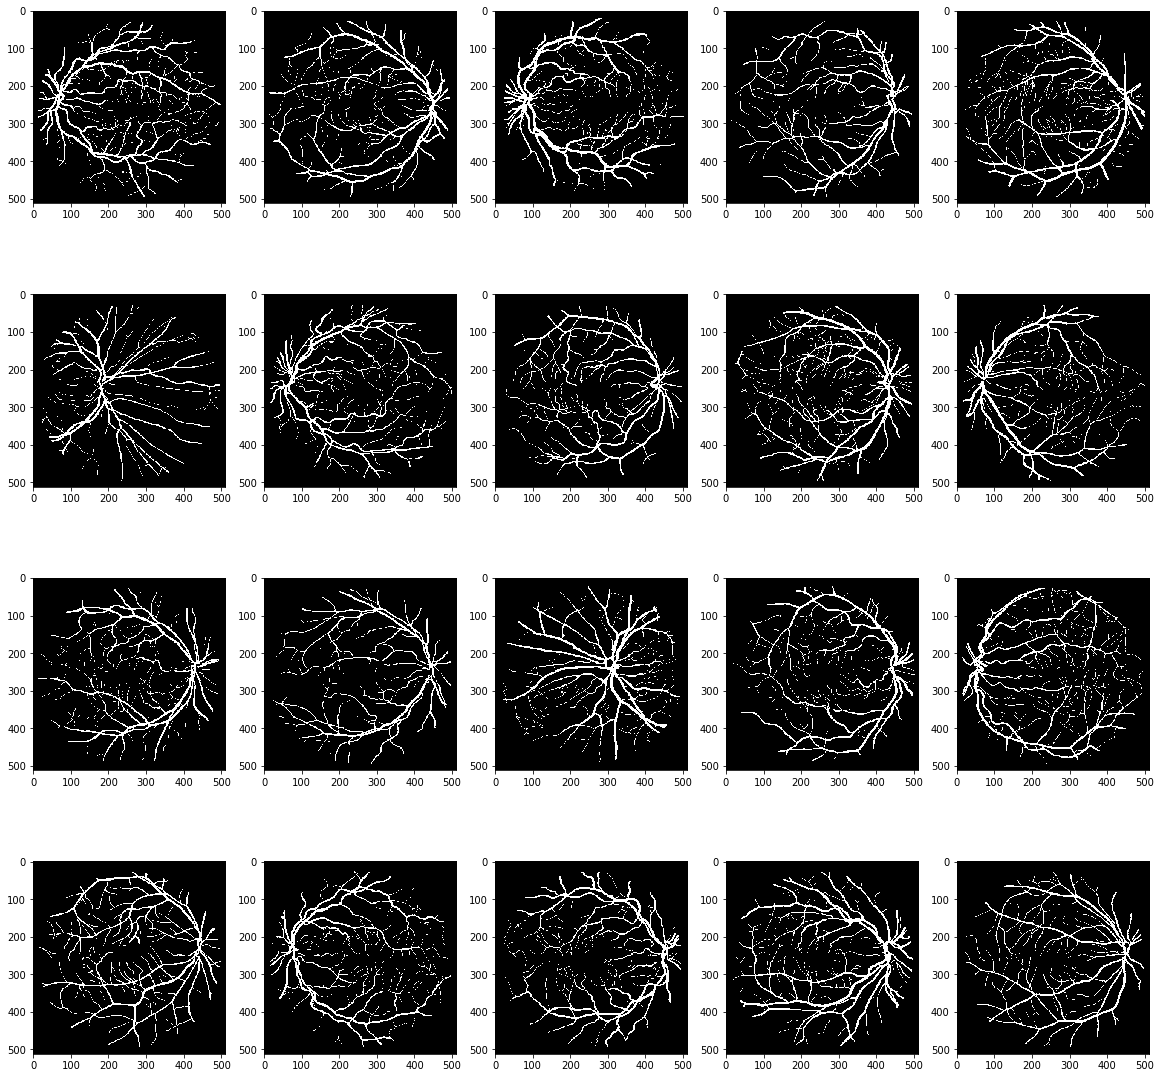

In [30]:
#rnd_ind = np.random.choice(20, 20, False)
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 4
for x, i in enumerate(rnd_ind):
    fig.add_subplot(rows, columns, x+1)
    plt.imshow(np.squeeze(bin_test_y[i]), cmap=plt.get_cmap('gray'))
plt.show()

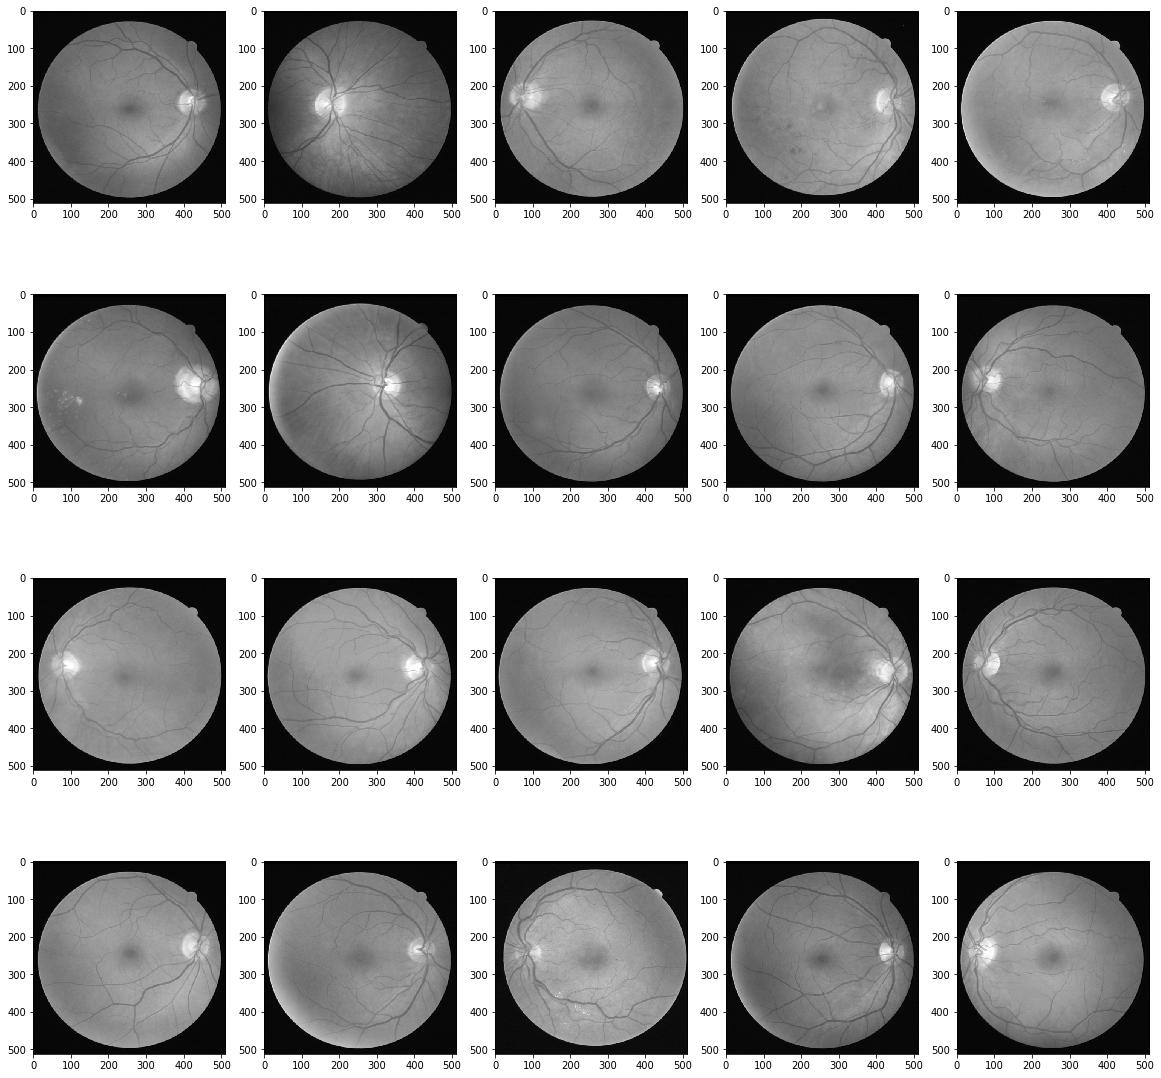

In [12]:
#rnd_ind = np.random.choice(20, 20, False)
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 4
for x, i in enumerate(rnd_ind):
    fig.add_subplot(rows, columns, x+1)
    plt.imshow(np.squeeze(test_x[i]), cmap=plt.get_cmap('gray'))
plt.show()

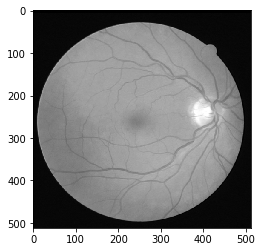

In [13]:
plt.imshow(np.squeeze(test_x[1]), cmap=plt.get_cmap('gray'))
plt.show()

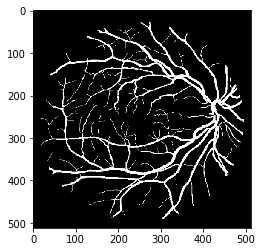

In [15]:
plt.imshow(np.squeeze(test_y[1]), cmap=plt.get_cmap('gray'))
plt.show()

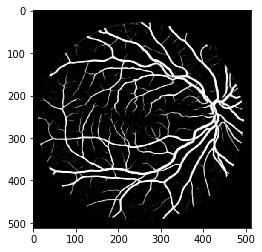

In [16]:
plt.imshow(np.squeeze(pred[1]), cmap=plt.get_cmap('gray'))
plt.show()

In [28]:
spl = np.random.choice(20, 3, False)
print(spl)
for suf in ['img_', 'lbl_', 'pred_']:
    if suf=='img_':
        data = test_x.compute()
    elif suf=='lbl_':
        data = test_y.compute()
    else:
        data = pred
    for i in spl:
        im = Image.fromarray(np.squeeze(data[i])*255.)
        im = im.convert("RGB")
        im.save(suf+str(i)+".png")

[2 4 7]
